## Understanding Variational Auto-Encoders

A notebook that explores the basic ideas behind VAEs

In [1]:
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
%matplotlib inline

np.random.seed(0)

Using TensorFlow backend.


In [3]:
"""
First, lets look at a standard autoencoder.
Demonstrated through the fashion mnist dataset
"""
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train / 255.
x_test = x_test / 255.
x_train = np.reshape(x_train, (x_train.shape[0], -1))
x_test = np.reshape(x_test, (x_test.shape[0], -1))
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(60000, 784) (60000,) (10000, 784) (10000,)


In [0]:
"""
Define the architecture of the network:
input layer -> 3 hidden layers -> output layer
that means 4 weight matrices and 4 biases
"""

n_input = 784  # input layer (28x28 pixels)
n_hidden1 = 128  # 1st hidden layer
n_hidden2 = 16  # 2nd hidden layer
n_hidden3 = 128  # 3rd hidden layer
n_output = 784  # output layer (0-9 digits)


# define hyperparameters 
learning_rate = 1e-4
n_iterations = 1000
batch_size = 128
# dropout = 0.5
display_freq = 100

# The main part: 
X = tf.placeholder("float", [None, n_input], name='X')
Y = tf.placeholder("float", [None, n_output], name='Y')
keep_prob = tf.placeholder(tf.float32)

weights = {
    'w1': tf.Variable(tf.truncated_normal([n_input, n_hidden1], stddev=0.1)),
    'w2': tf.Variable(tf.truncated_normal([n_hidden1, n_hidden2], stddev=0.1)),
    'w3': tf.Variable(tf.truncated_normal([n_hidden2, n_hidden3], stddev=0.1)),
    'out': tf.Variable(tf.truncated_normal([n_hidden3, n_output], stddev=0.1)),
}

biases = {
    'b1': tf.Variable(tf.constant(0.1, shape=[n_hidden1])),
    'b2': tf.Variable(tf.constant(0.1, shape=[n_hidden2])),
    'b3': tf.Variable(tf.constant(0.1, shape=[n_hidden3])),
    'out': tf.Variable(tf.constant(0.1, shape=[n_output]))
}

# define the graph
# TODO: add activation functions
layer_1 = tf.nn.relu(tf.add(tf.matmul(X, weights['w1']), biases['b1']))
layer_2 = tf.nn.relu(tf.add(tf.matmul(layer_1, weights['w2']), biases['b2']))
layer_3 = tf.nn.relu(tf.add(tf.matmul(layer_2, weights['w3']), biases['b3']))
# layer_drop = tf.nn.dropout(layer_3, rate=1-keep_prob)
output = tf.nn.relu(tf.matmul(layer_3, weights['out']) + biases['out'])

loss = tf.reduce_mean(
                tf.losses.mean_squared_error(labels=Y, predictions=output))
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)

In [0]:
cost = tf.reduce_mean(tf.cast(tf.losses.mean_squared_error(labels=Y, predictions=output), tf.float32))

In [42]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    for j in range(10):
        for i in range(600):
            img = x_train[i*100:i*100+100]
            x_batch, y_batch = img, img
            _, mse = sess.run([train_step, cost], feed_dict={X: x_batch, Y: y_batch})
            if i % display_freq == 0:
                print('Step {}, MSE={}'.format(i, mse))


Step 0, MSE=0.1660495102405548
Step 10, MSE=0.15784551203250885
Step 20, MSE=0.1565094292163849
Step 30, MSE=0.13768260180950165
Step 40, MSE=0.13434435427188873
Step 50, MSE=0.11871163547039032
Step 60, MSE=0.1217440590262413
Step 70, MSE=0.11036532372236252
Step 80, MSE=0.11033619195222855
Step 90, MSE=0.10345881432294846
Step 100, MSE=0.0934688001871109
Step 110, MSE=0.0945969969034195
Step 120, MSE=0.08565524220466614
Step 130, MSE=0.08550892025232315
Step 140, MSE=0.07881352305412292
Step 150, MSE=0.08232304453849792
Step 160, MSE=0.0719514787197113
Step 170, MSE=0.07212317734956741
Step 180, MSE=0.07111648470163345
Step 190, MSE=0.07552433013916016
Step 200, MSE=0.07210902869701385
Step 210, MSE=0.07108721137046814
Step 220, MSE=0.06982985883951187
Step 230, MSE=0.06862886250019073
Step 240, MSE=0.06533302366733551
Step 250, MSE=0.06665166467428207
Step 260, MSE=0.0663997232913971
Step 270, MSE=0.06472424417734146
Step 280, MSE=0.05786481127142906
Step 290, MSE=0.0654562041163444

(1, 784)


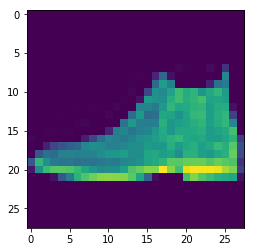

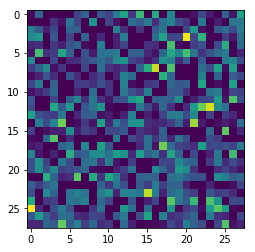

In [44]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    sample_img = np.expand_dims(x_test[0], axis=0)
    pred = sess.run(output, feed_dict={X:sample_img})
    print(pred.shape)
    img = np.reshape(sample_img, (28,28))
    pred = np.reshape(pred, (28,28))
    plt.imshow(img)
    plt.figure()
    plt.imshow(pred)

In [0]:
img1 = np.expand_dims(x_train[0],axis=0)
img2 = np.expand_dims(x_train[1], axis=0)
plt.imshow(img1.reshape(28,28))
plt.figure()
plt.imshow(img2.reshape(28,28))

training_data = tf.placeholder(tf.float32, [None, x_train.shape[1]])
labels = tf.placeholder(tf.float32, [None, x_train.shape[1]])

output = training_data + labels

with tf.Session() as sess:
    print(img1.shape, img2.shape)
    print(training_data.shape)
    ret = sess.run([output], feed_dict={training_data: img1, labels: img2})
    print(ret[0].shape)
    plt.figure()
    plt.imshow(ret[0].reshape(28,28))

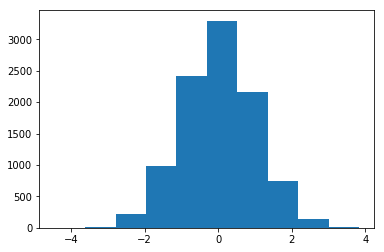

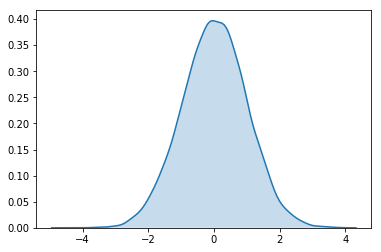

In [0]:
"""
Intermission: sampling from a distribution
"""
nsamples = 10000
y = np.random.np.random.normal(0,1,nsamples)
x = np.linspace(-10, 10, nsamples)

# plt.plot(y, x, '.')
plt.hist(y)
plt.figure()
sns.kdeplot(data=y, shade=True)